In [1]:
%load_ext watermark


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._shift_no_wrap import shift_no_wrap
from pylib.synthgeom._AttributeBoxMax import AttributeBoxMax
from pylib.synthgeom._VideoWriter import VideoWriter
from pylib.synthgeom._generate_observations import generate_observations

make_reproducible()


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-24T14:52:51.536577+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.9.2
numpy     : 1.23.5

Watermark: 2.4.3



In [4]:
SX, SY = 400, 400
crea_func = np.ones
crea_size = 10


def mirror_backtrack_transform(arr, i):
    return shift_no_wrap(arr, (min(i, SX // 4), -min(i, SY // 4)), axis=(0, 1))


In [5]:
def show_sample_observations(
    SX,
    SY,
    *,
    crea_func,
    crea_size=crea_size,
    every_nth=5,
    fps=30.0,
    logger=print,
    mirror_backtrack=False,
    mirror_backtrack_transform=mirror_backtrack_transform,
    num_frames=1000,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        crea_func=crea_func,
        crea_size=crea_size,
        mirror_backtrack=mirror_backtrack,
        mirror_backtrack_transform=mirror_backtrack_transform,
        num_frames=num_frames,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter("out.gif", fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter("out.gif", fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [6]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


## `crea_func=np.ones` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


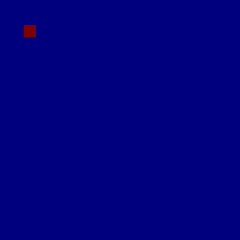

exit log_context_duration for Creating video
!!! {"Creating video": 4.832326412200928}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


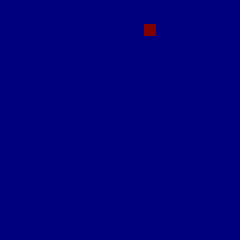

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.021593332290649}


100%|██████████| 16/16 [00:01<00:00, 13.73it/s]


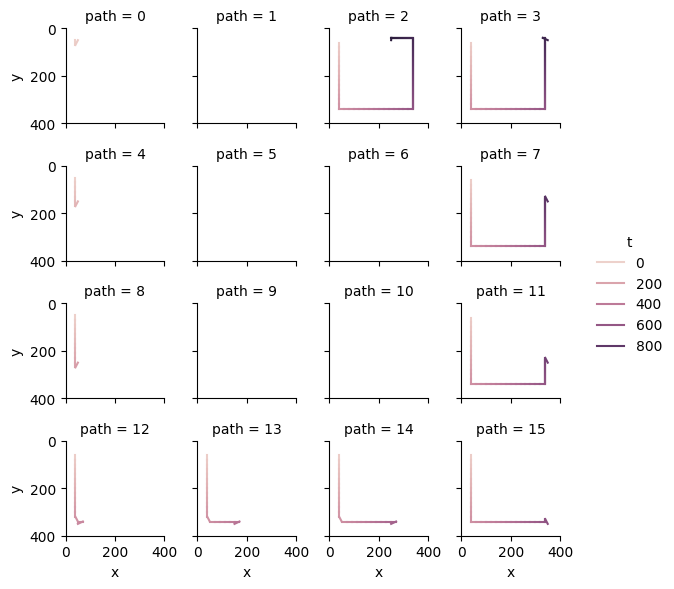

In [7]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    mirror_backtrack=False,
)
observations = pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(20))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()


## `crea_func=np.ones` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


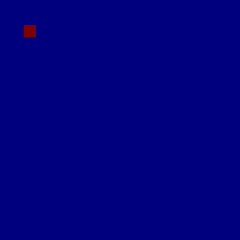

exit log_context_duration for Creating video
!!! {"Creating video": 4.442955493927002}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 2 colors in source)


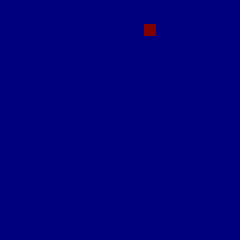

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.444522142410278}


100%|██████████| 16/16 [00:01<00:00, 10.88it/s]


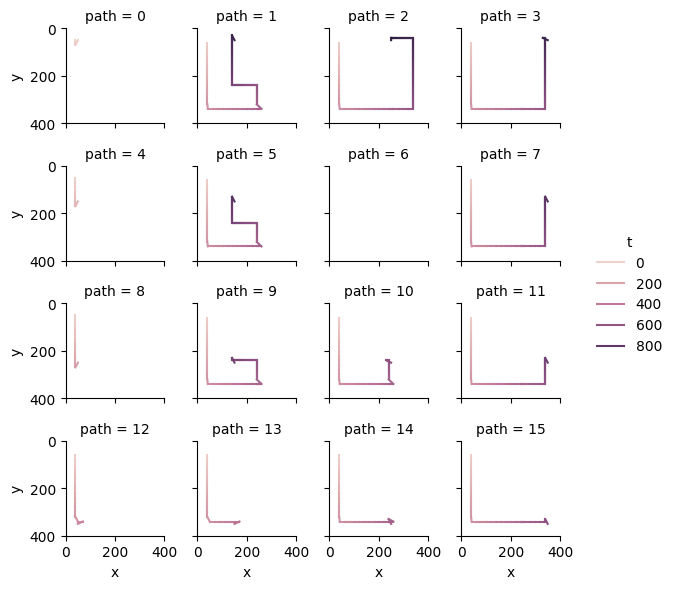

In [8]:
obvs = show_sample_observations(
    SX,
    SY,
    crea_func=np.ones,
    mirror_backtrack=True,
    mirror_backtrack_transform=mirror_backtrack_transform,
)
observations = pathsplot(
    [
        build_path(coordinate, obvs, AttributeBoxMax(20))
        for coordinate in tqdm(seed_coordinates)
    ],
    xmax=SX,
    ymax=SY,
    col_wrap=4,
)
plt.show()


## `crea_func=np.random.rand` `mirror_backtrack=False`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 206 colors in source)


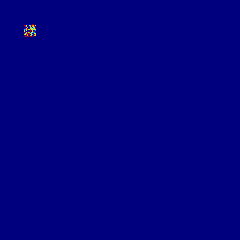

exit log_context_duration for Creating video
!!! {"Creating video": 5.5538530349731445}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 211 colors in source)


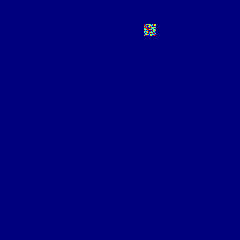

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.6952855587005615}


100%|██████████| 16/16 [00:01<00:00,  9.41it/s]


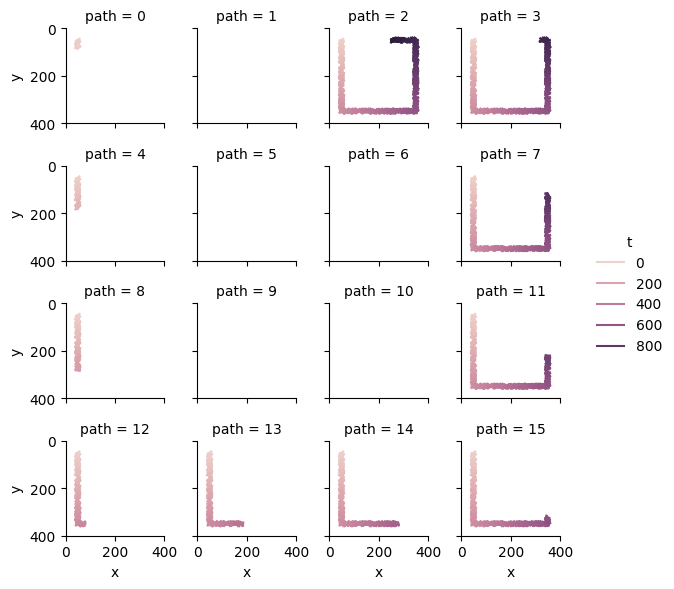

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 207 colors in source)


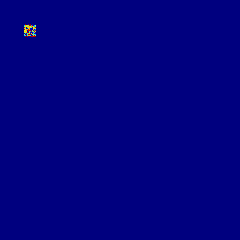

exit log_context_duration for Creating video
!!! {"Creating video": 5.919957876205444}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 203 colors in source)


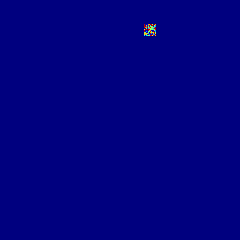

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.709680557250977}


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]


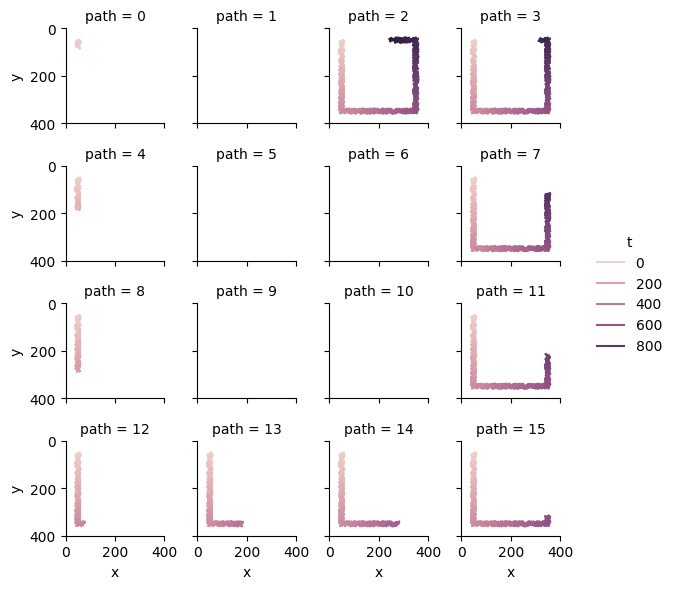

In [9]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        mirror_backtrack=False,
    )
    observations = pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(20))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()


## `crea_func=np.random.rand` `mirror_backtrack=True`


enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 216 colors in source)


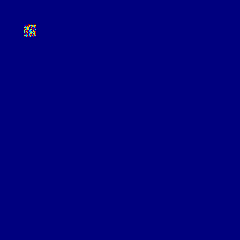

exit log_context_duration for Creating video
!!! {"Creating video": 5.809997320175171}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 215 colors in source)


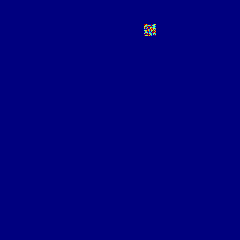

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.865605354309082}


100%|██████████| 16/16 [00:01<00:00,  8.83it/s]


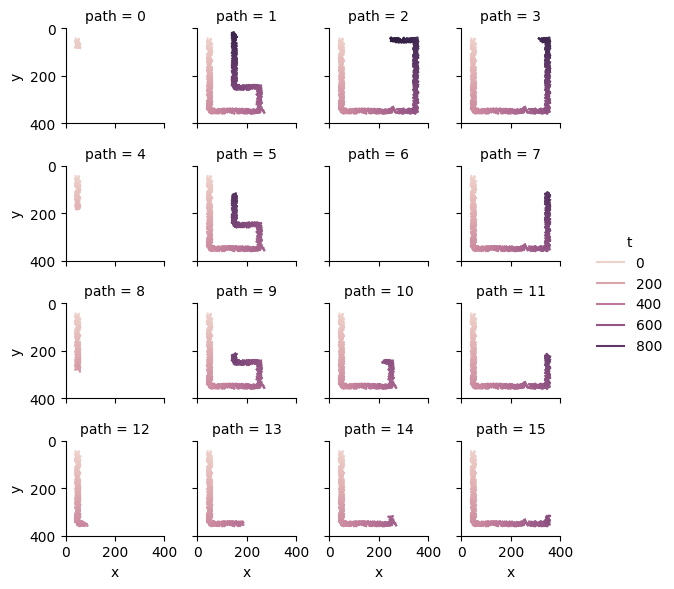

enter log_context_duration for Creating video


gifsicle: warning: trivial adaptive palette (only 214 colors in source)


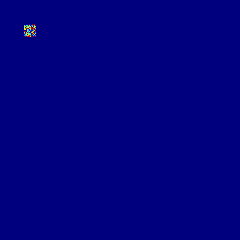

exit log_context_duration for Creating video
!!! {"Creating video": 5.793330669403076}
enter log_context_duration for Creating reversed video


gifsicle: warning: trivial adaptive palette (only 215 colors in source)


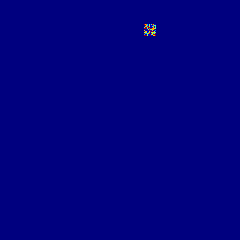

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.170740604400635}


100%|██████████| 16/16 [00:01<00:00,  9.27it/s]


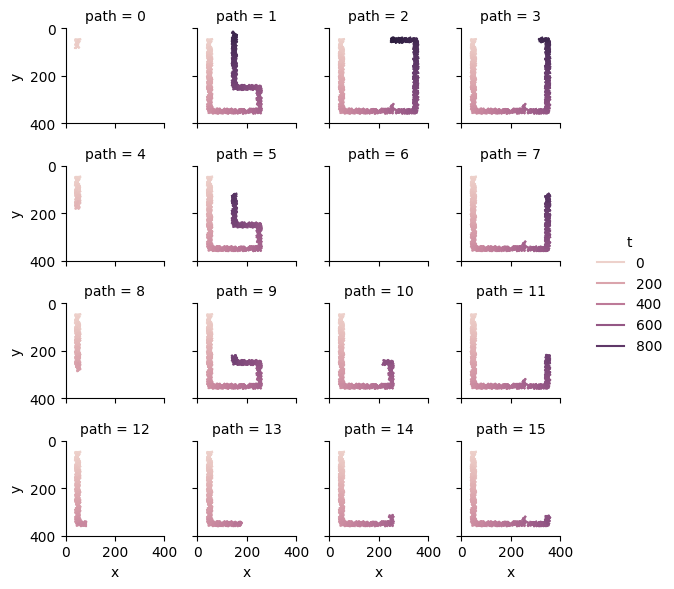

In [10]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        crea_func=lambda x: np.random.rand(*x),
        mirror_backtrack=True,
        mirror_backtrack_transform=mirror_backtrack_transform,
    )
    observations = pathsplot(
        [
            build_path(coordinate, obvs, AttributeBoxMax(20))
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()
